# Voice recognition for Japanese 

---

This notebook is based on Udacity AI nano degree's Voice User Interface.  
I tweaked a few part of utility scrits for Japanese, record 1670 sentences ( 171+ mins )   
And tried to train model.

---


In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

/home/aind2/anaconda3/envs/aind-vui/lib/python3.5/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


There are 1230 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

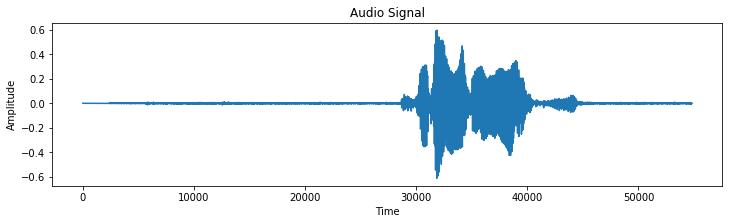

**Shape of Audio Signal** : (54785,)

**Transcript** : ぷろろーぐ

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

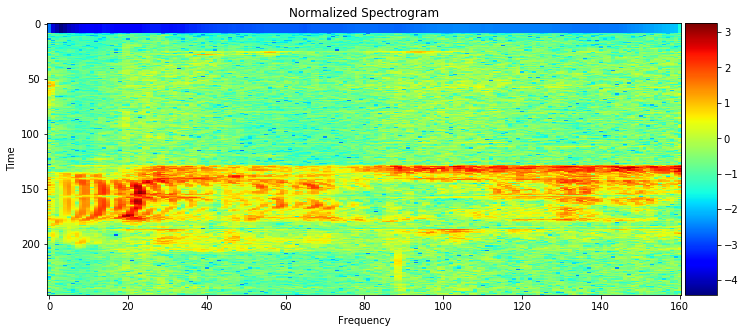

**Shape of Spectrogram** : (247, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

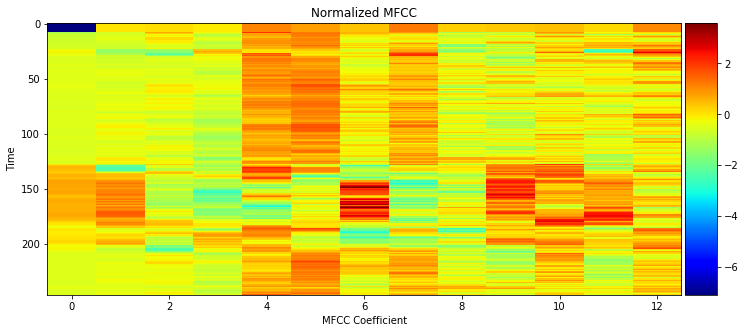

**Shape of MFCC** : (247, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 

# gpu specific
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

# Japanese Language

あいうえお かきくけこ さしすせそ たちつてと なにぬねの はひふへほ まみむめも やゆよ らりるれろ わをん -> 46  
ぁぃぅぇぉゃゅょゎっ -> 10  
がぎぐげご ざじずぜぞ だぢづでど ばびぶべぼ > 20  
ぱぴぷぺぽ > 5
ゔ > 1
ー > 1  
無音 > 1  
合計 > 84  

In [6]:
# index is from 1 to 85
# model_0 = simple_rnn_model(input_dim=161, output_dim=85) # change to 13 if you would like to use MFCC features
model_0 = simple_rnn_model(input_dim=13, output_dim=85) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 85)          25245     
_________________________________________________________________
softmax (Activation)         (None, None, 85)          0         
Total params: 25,245
Trainable params: 25,245
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
61/61 [==============================] - 81s - loss: 1399.4398 - val_loss: 1293.4748
Epoch 2/20
61/61 [==============================] - 80s - loss: 1266.4105 - val_loss: 1322.6320
Epoch 3/20
61/61 [==============================] - 80s - loss: 1267.1186 - val_loss: 1302.5386
Epoch 4/20
61/61 [==============================] - 80s - loss: 1265.6240 - val_loss: 1302.3172
Epoch 5/20
61/61 [==============================] - 80s - loss: 1264.0021 - val_loss: 1291.4078
Epoch 6/20
61/61 [==============================] - 80s - loss: 1265.6585 - val_loss: 1298.5010
Epoch 7/20
61/61 [==============================] - 81s - loss: 1264.6088 - val_loss: 1293.7898
Epoch 8/20
61/61 [==============================] - 79s - loss: 1263.7061 - val_loss: 1276.0984
Epoch 9/20
61/61 [==============================] - 80s - loss: 1264.9539 - val_loss: 1301.5428
Epoch 10/20
61/61 [==============================] - 79s - loss: 1264.6921 - val_loss: 1303.0824
Epoch 11/20
61/61 [====================

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [2]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu',
                    output_dim=85)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 85)          17085     
_________________________________________________________________
softmax (Activation)         (None, None, 85)          0         
Total params: 146,285
Trainable params: 145,885
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
89s - loss: 359.5376 - val_loss: 231.9518
Epoch 2/20
87s - loss: 88.6610 - val_loss: 207.4911
Epoch 3/20
85s - loss: 59.1090 - val_loss: 185.7374
Epoch 4/20
87s - loss: 43.9879 - val_loss: 153.1041
Epoch 5/20
86s - loss: 35.1108 - val_loss: 81.2763
Epoch 6/20
86s - loss: 29.3170 - val_loss: 42.4030
Epoch 7/20
87s - loss: 25.9211 - val_loss: 28.3801
Epoch 8/20
87s - loss: 23.1927 - val_loss: 23.4895
Epoch 9/20
86s - loss: 21.5432 - val_loss: 22.9955
Epoch 10/20
86s - loss: 19.6879 - val_loss: 21.8165
Epoch 11/20
86s - loss: 18.6427 - val_loss: 18.3402
Epoch 12/20
85s - loss: 17.7500 - val_loss: 19.1010
Epoch 13/20
86s - loss: 16.4413 - val_loss: 17.6379
Epoch 14/20
85s - loss: 15.8641 - val_loss: 15.3611
Epoch 15/20
86s - loss: 14.9459 - val_loss: 15.5049
Epoch 16/20
86s - loss: 14.4468 - val_loss: 16.3476
Epoch 17/20
86s - loss: 13.6960 - val_loss: 15.2989
Epoch 18/20
86s - loss: 13.3613 - val_loss: 13.9782
Epoch 19/20
85s - loss: 12.7873 - val_loss: 12.5904
Epoch 20/20
85s 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [4]:
model_2 = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        output_dim=85)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 85)          17085     
_________________________________________________________________
softmax (Activation)         (None, None, 85)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [6]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
26s - loss: 186.0613 - val_loss: 110.4133
Epoch 2/20
23s - loss: 50.0777 - val_loss: 72.4996
Epoch 3/20
24s - loss: 29.6262 - val_loss: 40.9511
Epoch 4/20
24s - loss: 23.1548 - val_loss: 27.6812
Epoch 5/20
22s - loss: 19.9526 - val_loss: 18.4811
Epoch 6/20
24s - loss: 17.6266 - val_loss: 17.3081
Epoch 7/20
23s - loss: 15.9014 - val_loss: 15.6515
Epoch 8/20
24s - loss: 14.6957 - val_loss: 14.7129
Epoch 9/20
24s - loss: 13.3844 - val_loss: 17.5702
Epoch 10/20
24s - loss: 12.6611 - val_loss: 13.2436
Epoch 11/20
23s - loss: 11.7400 - val_loss: 11.9438
Epoch 12/20
24s - loss: 10.7804 - val_loss: 11.6400
Epoch 13/20
23s - loss: 10.4195 - val_loss: 11.2064
Epoch 14/20
25s - loss: 9.5931 - val_loss: 11.2541
Epoch 15/20
23s - loss: 9.1449 - val_loss: 10.1959
Epoch 16/20
24s - loss: 8.4639 - val_loss: 10.0064
Epoch 17/20
23s - loss: 8.2517 - val_loss: 9.5402
Epoch 18/20
23s - loss: 7.7977 - val_loss: 8.6364
Epoch 19/20
24s - loss: 7.4751 - val_loss: 10.2149
Epoch 20/20
23s - loss: 7.2

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [9]:
model_3 = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         output_dim=85) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 85)          17085     
_________________________________________________________________
softmax (Activation)         (None, None, 85)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [10]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
163s - loss: 495.6770 - val_loss: 195.7849
Epoch 2/20
163s - loss: 151.3757 - val_loss: 142.4536
Epoch 3/20
162s - loss: 128.7162 - val_loss: 130.0719
Epoch 4/20
162s - loss: 110.4170 - val_loss: 107.9297
Epoch 5/20
162s - loss: 85.1040 - val_loss: 88.7280
Epoch 6/20
162s - loss: 62.7614 - val_loss: 79.7157
Epoch 7/20
163s - loss: 45.8115 - val_loss: 54.4053
Epoch 8/20
162s - loss: 35.1769 - val_loss: 39.0615
Epoch 9/20
163s - loss: 29.3062 - val_loss: 29.5970
Epoch 10/20
164s - loss: 25.4099 - val_loss: 25.4844
Epoch 11/20
162s - loss: 22.9058 - val_loss: 22.3367
Epoch 12/20
161s - loss: 21.1273 - val_loss: 20.7285
Epoch 13/20
163s - loss: 19.6896 - val_loss: 18.9932
Epoch 14/20
162s - loss: 17.9001 - val_loss: 16.7459
Epoch 15/20
164s - loss: 16.8519 - val_loss: 17.1642
Epoch 16/20
163s - loss: 15.6537 - val_loss: 15.8556
Epoch 17/20
162s - loss: 14.8766 - val_loss: 16.0015
Epoch 18/20
163s - loss: 14.4124 - val_loss: 14.8207
Epoch 19/20
163s - loss: 13.5589 - val_loss: 15

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [11]:
model_4 = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features or 161
                                  units=200,
                                  output_dim=85)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 85)          34085     
_________________________________________________________________
softmax (Activation)         (None, None, 85)          0         
Total params: 290,885
Trainable params: 290,885
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [12]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
156s - loss: 368.9123 - val_loss: 121.9044
Epoch 2/20
157s - loss: 97.5584 - val_loss: 85.9281
Epoch 3/20
154s - loss: 70.2320 - val_loss: 64.6917
Epoch 4/20
157s - loss: 52.6111 - val_loss: 47.4896
Epoch 5/20
157s - loss: 40.5024 - val_loss: 37.8461
Epoch 6/20
155s - loss: 32.1479 - val_loss: 30.2981
Epoch 7/20
155s - loss: 27.1627 - val_loss: 26.2739
Epoch 8/20
156s - loss: 23.9423 - val_loss: 23.2824
Epoch 9/20
157s - loss: 21.4684 - val_loss: 21.4849
Epoch 10/20
157s - loss: 19.5476 - val_loss: 18.9249
Epoch 11/20
155s - loss: 18.1407 - val_loss: 18.5522
Epoch 12/20
156s - loss: 16.8407 - val_loss: 18.0094
Epoch 13/20
156s - loss: 15.6414 - val_loss: 15.1013
Epoch 14/20
155s - loss: 14.7722 - val_loss: 14.3125
Epoch 15/20
156s - loss: 13.8875 - val_loss: 14.1520
Epoch 16/20
154s - loss: 13.1283 - val_loss: 12.8444
Epoch 17/20
156s - loss: 12.2226 - val_loss: 11.9871
Epoch 18/20
157s - loss: 11.7166 - val_loss: 11.9071
Epoch 19/20
156s - loss: 10.9742 - val_loss: 11.2702


<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [13]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

/home/aind2/anaconda3/envs/aind-vui/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


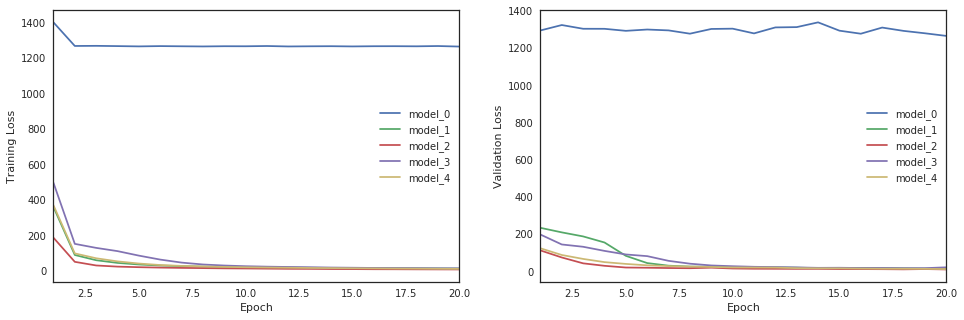

In [14]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
# specify the model
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        output_dim=85)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 85)          34085     
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
171s - loss: 217.4489 - val_loss: 134.2593
Epoch 2/20
170s - loss: 91.2612 - val_loss: 91.2295
Epoch 3/20
166s - loss: 51.8411 - val_loss: 50.9931
Epoch 4/20
165s - loss: 34.4563 - val_loss: 33.0314
Epoch 5/20
163s - loss: 26.1011 - val_loss: 21.8671
Epoch 6/20
164s - loss: 21.5310 - val_loss: 17.7306
Epoch 7/20
162s - loss: 18.2225 - val_loss: 13.7399
Epoch 8/20
163s - loss: 16.1819 - val_loss: 12.2524
Epoch 9/20
163s - loss: 14.0644 - val_loss: 10.2115
Epoch 10/20
162s - loss: 12.3045 - val_loss: 9.5464
Epoch 11/20
162s - loss: 11.0151 - val_loss: 8.2371
Epoch 12/20
162s - loss: 9.8832 - val_loss: 7.3541
Epoch 13/20
162s - loss: 9.0148 - val_loss: 6.7663
Epoch 14/20
161s - loss: 7.9740 - val_loss: 5.8303
Epoch 15/20
161s - loss: 7.1619 - val_loss: 6.1320
Epoch 16/20
163s - loss: 6.3848 - val_loss: 5.4944
Epoch 17/20
164s - loss: 6.0190 - val_loss: 4.7443
Epoch 18/20
164s - loss: 5.3742 - val_loss: 4.5267
Epoch 19/20
163s - loss: 4.9303 - val_loss: 4.2951
Epoch 20/20
163s -

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [9]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
#     data_gen = AudioGenerator()
    data_gen = AudioGenerator(spectrogram=False, mfcc_dim=13)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [10]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        output_dim=85), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 400)         1600      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 85)          34085     
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [12]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        output_dim=85), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 400)         481200    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 400)         1600      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 85)          34085     
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!